# Odhad CDPF

## Cíl analýzy

## Data a metoda

NAMA_10_A10

In [99]:
import eurostat
import pandas
import numpy

LOCATIONS = ["CZ", "DE", "AT", "EU27_2020", "ES"]
BASE_LOCATION = "CZ"
START_YEAR = 1980
END_YEAR = 2020

### Hrubá přidaná hodnota (Gross Value Added)

In [100]:
data_1_es = eurostat.get_data_df('nama_10_a10')

In [101]:
data_1 = data_1_es
# Value added, gross
data_1 = data_1[data_1["na_item"] == "B1G"]
# Total, all NACE activities
data_1 = data_1[data_1["nace_r2"] == "TOTAL"]
# Current prices, million euro
data_1 = data_1[data_1["unit"].isin(["CP_MNAC", "PD10_NAC"])]
data_1 = pandas.melt(data_1, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                     value_name="value", var_name="year")
data_1 = data_1.pivot(index=["na_item", "geo\\time", "year"], columns="unit", values="value")
data_1 = data_1.reset_index()
data_1 = data_1.rename({"CP_MNAC": "gross_value_added", "PD10_NAC": "gross_value_added_deflator"}, axis=1)
data_1["gross_value_added"] = data_1["gross_value_added"] * data_1["gross_value_added_deflator"]
data_1 = data_1.drop("gross_value_added_deflator", axis=1)
data_1 = data_1.dropna()
data_1.tail()

In [102]:
data_1 = data_1.sort_values(["geo\\time", "year"])
data_1["ln_gross_value_added"] = numpy.log(data_1["gross_value_added"])
data_1["ln_gross_value_added_t_minus_1"] = data_1.groupby("geo\\time")["ln_gross_value_added"].shift(1)
data_1["ln_gross_value_added_diff"] = (data_1["ln_gross_value_added"] - data_1["ln_gross_value_added_t_minus_1"]) / data_1["ln_gross_value_added"]
data_1.tail()

unit,na_item,geo\time,year,gross_value_added,ln_gross_value_added,ln_gross_value_added_t_minus_1,ln_gross_value_added_diff
1840,B1G,XK,2016,547200.4080,13.212570,13.159562,0.004012
1841,B1G,XK,2017,577304.7840,13.266126,13.212570,0.004037
1842,B1G,XK,2018,617278.2520,13.333075,13.266126,0.005021
1843,B1G,XK,2019,661185.7636,13.401790,13.333075,0.005127
1844,B1G,XK,2020,660210.0975,13.400313,13.401790,-0.000110


geo\time
AT           AxesSubplot(0.125,0.125;0.775x0.755)
CZ           AxesSubplot(0.125,0.125;0.775x0.755)
DE           AxesSubplot(0.125,0.125;0.775x0.755)
ES           AxesSubplot(0.125,0.125;0.775x0.755)
EU27_2020    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ln_gross_value_added_diff, dtype: object

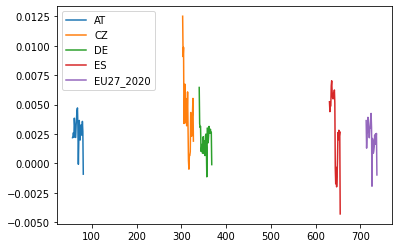

In [105]:
data_1[data_1["geo\\time"].isin(LOCATIONS)].dropna().groupby("geo\\time")["ln_gross_value_added_diff"].plot(legend=True)

In [ ]:
data_2_es = eurostat.get_data_df('nama_10_a10_e')

In [ ]:
data_2 = data_2_es
# Total employment domestic concept
data_2 = data_2[data_2["na_item"] == "EMP_DC"]
# Total, all NACE activities
data_2 = data_2[data_2["nace_r2"] == "TOTAL"]
# Thousands hours worked
data_2 = data_2[data_2["unit"] == "THS_HW"]
data_2 = pandas.melt(data_2, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="thousands_hours_worked", var_name="year")
data_2 = data_2.sort_values(["geo\\time", "year"])
data_2 = data_2.dropna()
data_2["ln_thousands_hours_worked"] = numpy.log(data_2["thousands_hours_worked"])
data_2["ln_thousands_hours_worked_t_minus_1"] = data_2.groupby("geo\\time")["ln_thousands_hours_worked"].shift(1)
data_2["ln_thousands_hours_worked_diff"] = (data_2["ln_thousands_hours_worked"] - data_2["ln_thousands_hours_worked_t_minus_1"]) / data_2["ln_thousands_hours_worked"]
data_2.head()

In [ ]:
data_3_es = eurostat.get_data_df('nama_10_nfa_bs')

In [ ]:
data_3 = data_3_es
data_3 = eurostat.get_data_df('nama_10_nfa_bs')
# Total fixed assets (net)
data_3 = data_3[data_3["asset10"] == "N11N"]
# Total, all activities
data_3 = data_3[data_3["sector"] == "S1"]
# Current fixed prices, millions of national currency
data_3 = data_3[data_3["unit"] == "CP_MNAC"]
data_3 = pandas.melt(data_3, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="total_fixed_assets", var_name="year")
data_3 = data_3.sort_values(["geo\\time", "year"])
data_3 = data_3.dropna()
data_3["ln_total_fixed_assets"] = numpy.log(data_3["total_fixed_assets"])
data_3["ln_total_fixed_assets_t_minus_1"] = data_3.groupby("geo\\time")["ln_total_fixed_assets"].shift(1)
data_3["ln_total_fixed_assets_diff"] = (data_3["ln_total_fixed_assets"] - data_3["ln_total_fixed_assets_t_minus_1"]) / data_3["ln_total_fixed_assets"]
data_3.tail()

In [ ]:
data_4_es = eurostat.get_data_df('nama_10_nfa_fl')

In [ ]:
data_4 = data_4_es
#
data_4 = data_4[data_4["asset10"] == "N11G"]
#
data_4 = data_4[data_4["nace_r2"] == "TOTAL"]
#
data_4 = data_4[data_4["unit"] == "PD10_NAC"]
data_4 = pandas.melt(data_4, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="capital_stock_deflator", var_name="year")
data_4 = data_4.sort_values(["geo\\time", "year"])
data_4 = data_4.dropna()
data_4["ln_capital_stock_deflator"] = numpy.log(data_4["capital_stock_deflator"])
data_4["ln_capital_stock_deflator_t_minus_1"] = data_4.groupby("geo\\time")["ln_capital_stock_deflator"].shift(1)
data_4["ln_capital_stock_deflators_diff"] = (data_4["ln_capital_stock_deflator"] - data_4["ln_capital_stock_deflator_t_minus_1"]) / data_4["ln_capital_stock_deflator"]
data_4.tail()